In [1]:
import sys
import pickle
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
import pandas as pd
import sys
import pickle
import csv
import matplotlib.pyplot as plt

sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
#from poi_data import *
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

from numpy import mean

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.metrics import accuracy_score, precision_score, recall_score

#%%

In [2]:
#% ## Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
#features_list = ['poi','salary'] # You will need to use more features

############# Task 1: Select what features you'll use.############

target_label = 'poi'

email_features_list = [
    'from_messages',
    'from_poi_to_this_person',
    'from_this_person_to_poi',
    'shared_receipt_with_poi',
    'to_messages',
    ]
    
financial_features_list = [
    'bonus',
    'deferral_payments',
    'deferred_income',
    'director_fees',
    'exercised_stock_options',
    'expenses',
    'loan_advances',
    'long_term_incentive',
    'other',
    'restricted_stock',
    'restricted_stock_deferred',
    'salary',
    'total_payments',
    'total_stock_value',
]

features_list = [target_label] + financial_features_list + email_features_list

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)
    
### 1.1.0 Explore csv file 
def make_csv(data_dict):
    """ generates a csv file from a data set"""
    fieldnames = ['name'] + data_dict.itervalues().next().keys()
    with open('data.csv', 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for record in data_dict:
            person = data_dict[record]
            person['name'] = record
            assert set(person.keys()) == set(fieldnames)
            writer.writerow(person)

### 1.1.1 Dataset Exploration
print('# Exploratory Data Analysis #')
data_dict.keys()
print('Total number of data points: %d' % len(data_dict.keys()))
num_poi = 0
for name in data_dict.keys():
    if data_dict[name]['poi'] == True:
        num_poi += 1
print('Number of Persons of Interest: %d' % num_poi)
print('Number of people without Person of Interest label: %d' % (len(data_dict.keys()) - num_poi))


###1.1.2 Feature Exploration
all_features = data_dict['ALLEN PHILLIP K'].keys()
print('Each person has %d features available' %  len(all_features))
### Evaluate dataset for completeness
missing_values = {}
for feature in all_features:
    missing_values[feature] = 0
for person in data_dict.keys():
    records = 0
    for feature in all_features:
        if data_dict[person][feature] == 'NaN':
            missing_values[feature] += 1
        else:
            records += 1

### Print results of completeness analysis
print('Number of Missing Values for Each Feature:')
for feature in all_features:
    print("%s: %d" % (feature, missing_values[feature]))

#%%


# Exploratory Data Analysis #
Total number of data points: 146
Number of Persons of Interest: 18
Number of people without Person of Interest label: 128
Each person has 21 features available
Number of Missing Values for Each Feature:
salary: 51
to_messages: 60
deferral_payments: 107
total_payments: 21
loan_advances: 142
bonus: 64
email_address: 35
restricted_stock_deferred: 128
deferred_income: 97
total_stock_value: 20
expenses: 51
from_poi_to_this_person: 60
exercised_stock_options: 44
from_messages: 60
other: 53
from_this_person_to_poi: 60
poi: 0
long_term_incentive: 80
shared_receipt_with_poi: 60
restricted_stock: 36
director_fees: 129


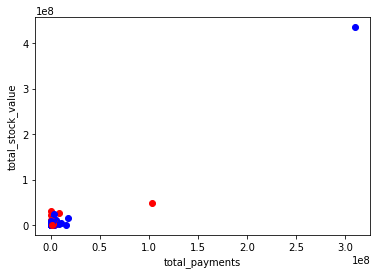

None


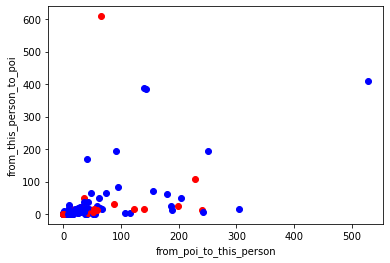

None


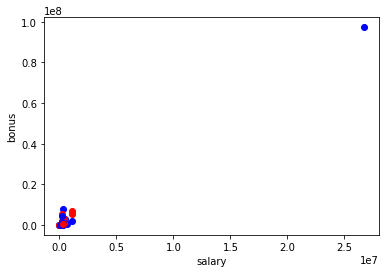

None


In [3]:
################# Task 2: Remove outliers #####################

def PlotOutlier(data_dict, feature_x, feature_y):
    """ Plot with flag = True in Red """
    data = featureFormat(data_dict, [feature_x, feature_y, 'poi'])
    for point in data:
        x = point[0]
        y = point[1]
        poi = point[2]
        if poi:
            color = 'red'
        else:
            color = 'blue'
        plt.scatter(x, y, color=color)
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.show()

# 2.1 Visualise outliers
print(PlotOutlier(data_dict, 'total_payments', 'total_stock_value'))
print(PlotOutlier(data_dict, 'from_poi_to_this_person', 'from_this_person_to_poi'))
print(PlotOutlier(data_dict, 'salary', 'bonus'))
#Remove outlier TOTAL line in pickle file.
data_dict.pop( 'TOTAL', 0 )


# 2.2 Function to remove outliers
def remove_outlier(dict_object, keys):
    """ removes list of outliers keys from dict object """
    for key in keys:
        dict_object.pop(key, 0)

outliers = ['TOTAL', 'THE TRAVEL AGENCY IN THE PARK', 'LOCKHART EUGENE E','FREVERT MARK A','LAVARATO JOHN J',"SKILLING JEFFREY K","LAY KENNETH L"]
remove_outlier(data_dict, outliers)



#%%


In [4]:
import matplotlib.pyplot
def showData(data_set, first_feature, second_feature):
    data = featureFormat(data_set, [first_feature, second_feature, 'poi'])
    for point in data:
        x = point[0]
        y = point[1]
        poi = point[2]
        if poi:
            color = 'red'
        else:
            color = 'blue'
        matplotlib.pyplot.scatter(x, y, color=color)

    matplotlib.pyplot.xlabel(first_feature)
    matplotlib.pyplot.ylabel(second_feature)
    matplotlib.pyplot.show()

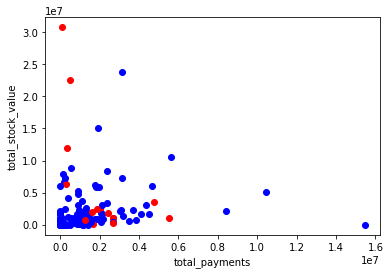

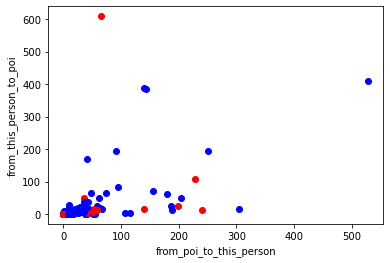

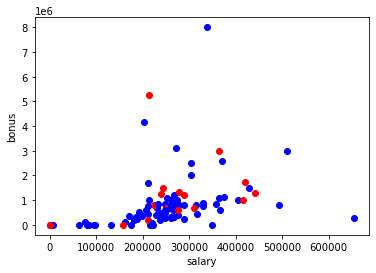

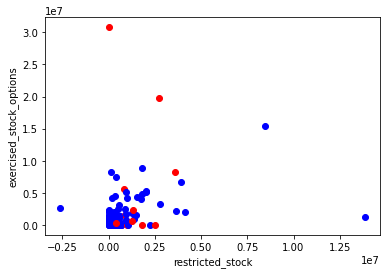

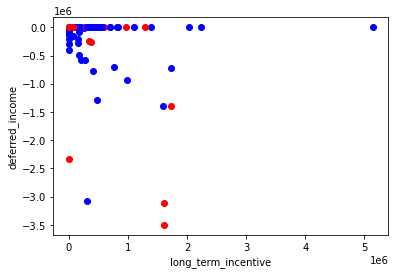

In [5]:
# Visualize data to identify outliers
# data_dict.T.to_dict
# data_dict.pop('LAY KENNETH L',0)
showData(data_dict, 'total_payments','total_stock_value')
showData(data_dict, 'from_poi_to_this_person', 'from_this_person_to_poi')
showData(data_dict, 'salary', 'bonus')
showData(data_dict, 'restricted_stock', 'exercised_stock_options')
showData(data_dict, 'long_term_incentive', 'deferred_income')

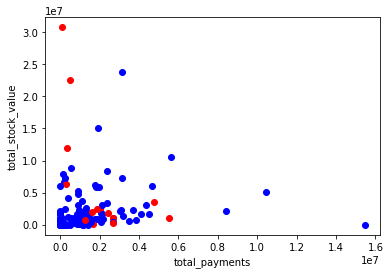

None


In [6]:
print(PlotOutlier(data_dict, 'total_payments', 'total_stock_value'))

In [7]:
### 1.1.0 Explore csv file 
def make_csv(data_dict):
    """ generates a csv file from a data set"""
    fieldnames = ['name'] + data_dict.itervalues().next().keys()
    with open('data.csv', 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for record in data_dict:
            person = data_dict[record]
            person['name'] = record
            assert set(person.keys()) == set(fieldnames)
            writer.writerow(person)

### 1.1.1 Dataset Exploration
print('# Exploratory Data Analysis #')
data_dict.keys()
print('Total number of data points: %d' % len(data_dict.keys()))
num_poi = 0
for name in data_dict.keys():
    if data_dict[name]['poi'] == True:
        num_poi += 1
print('Number of Persons of Interest: %d' % num_poi)
print('Number of people without Person of Interest label: %d' % (len(data_dict.keys()) - num_poi))


###1.1.2 Feature Exploration
all_features = data_dict['ALLEN PHILLIP K'].keys()
print('Each person has %d features available' %  len(all_features))
### Evaluate dataset for completeness
missing_values = {}
for feature in all_features:
    missing_values[feature] = 0
for person in data_dict.keys():
    records = 0
    for feature in all_features:
        if data_dict[person][feature] == 'NaN':
            missing_values[feature] += 1
        else:
            records += 1

### Print results of completeness analysis
print('Number of Missing Values for Each Feature:')
for feature in all_features:
    print("%s: %d" % (feature, missing_values[feature]))

#%%

# Exploratory Data Analysis #
Total number of data points: 140
Number of Persons of Interest: 16
Number of people without Person of Interest label: 124
Each person has 21 features available
Number of Missing Values for Each Feature:
salary: 49
to_messages: 57
deferral_payments: 104
total_payments: 20
loan_advances: 139
bonus: 62
email_address: 32
restricted_stock_deferred: 123
deferred_income: 94
total_stock_value: 18
expenses: 49
from_poi_to_this_person: 57
exercised_stock_options: 42
from_messages: 57
other: 52
from_this_person_to_poi: 57
poi: 0
long_term_incentive: 78
shared_receipt_with_poi: 57
restricted_stock: 34
director_fees: 124


In [8]:
df=pd.DataFrame.from_dict(data_dict)
df.T

salary to_messages deferral_payments total_payments  \
METTS MARK            365788         807               NaN        1061827   
BAXTER JOHN C         267102         NaN           1295738        5634343   
ELLIOTT STEVEN        170941         NaN               NaN         211725   
CORDES WILLIAM R         NaN         764               NaN            NaN   
HANNON KEVIN P        243293        1045               NaN         288682   
...                      ...         ...               ...            ...   
GRAMM WENDY L            NaN         NaN               NaN         119292   
CAUSEY RICHARD A      415189        1892               NaN        1868758   
TAYLOR MITCHELL S     265214         533            227449        1092663   
DONAHUE JR JEFFREY M  278601         865               NaN         875760   
GLISAN JR BEN F       274975         873               NaN        1272284   

                     loan_advances    bonus              email_address  \
METTS MARK                     NaN   600000       mark.metts@enron.com   
BAXTER JOHN C                  NaN  1200000                        NaN   
ELLIOTT STEVEN                 NaN   350000   steven.elliott@enron.com   
CORDES WILLIAM R               NaN      NaN      bill.cordes@enron.com   
HANNON KEVIN P                 NaN  1500000     kevin.hannon@enron.com   
...                            ...      ...                        ...   
GRAMM WENDY L                  NaN      NaN                        NaN   
CAUSEY RICHARD A               NaN  1000000   richard.causey@enron.com   
TAYLOR MITCHELL S              NaN   600000  mitchell.taylor@enron.com   
DONAHUE JR JEFFREY M           NaN   800000     jeff.donahue@enron.com   
GLISAN JR BEN F                NaN   600000       ben.glisan@enron.com   

                     restricted_stock_deferred deferred_income  \
METTS MARK                                 NaN             NaN   
BAXTER JOHN C                              NaN        -1386055   
ELLIOTT STEVEN                             NaN         -400729   
CORDES WILLIAM R                           NaN             NaN   
HANNON KEVIN P                             NaN        -3117011   
...                                        ...             ...   
GRAMM WENDY L                              NaN             NaN   
CAUSEY RICHARD A                           NaN         -235000   
TAYLOR MITCHELL S                          NaN             NaN   
DONAHUE JR JEFFREY M                       NaN         -300000   
GLISAN JR BEN F                            NaN             NaN   

                     total_stock_value  ... from_poi_to_this_person  \
METTS MARK                      585062  ...                      38   
BAXTER JOHN C                 10623258  ...                     NaN   
ELLIOTT STEVEN                 6678735  ...                     NaN   
CORDES WILLIAM R               1038185  ...                      10   
HANNON KEVIN P                 6391065  ...                      32   
...                                ...  ...                     ...   
GRAMM WENDY L                      NaN  ...                     NaN   
CAUSEY RICHARD A               2502063  ...                      58   
TAYLOR MITCHELL S              3745048  ...                       0   
DONAHUE JR JEFFREY M           1080988  ...                     188   
GLISAN JR BEN F                 778546  ...                      52   

                     exercised_stock_options from_messages    other  \
METTS MARK                               NaN            29     1740   
BAXTER JOHN C                        6680544           NaN  2660303   
ELLIOTT STEVEN                       4890344           NaN    12961   
CORDES WILLIAM R                      651850            12      NaN   
HANNON KEVIN P                       5538001            32    11350   
...                                      ...           ...      ...   
GRAMM WENDY L                            NaN           NaN      N

In [14]:
df.T.columns

Index(['salary', 'to_messages', 'deferral_payments', 'total_payments',
       'loan_advances', 'bonus', 'email_address', 'restricted_stock_deferred',
       'deferred_income', 'total_stock_value', 'expenses',
       'from_poi_to_this_person', 'exercised_stock_options', 'from_messages',
       'other', 'from_this_person_to_poi', 'poi', 'long_term_incentive',
       'shared_receipt_with_poi', 'restricted_stock', 'director_fees'],
      dtype='object')

In [18]:
df.T.replace(to_replace='NaN', value=np.nan, inplace=True)
df.T['salary']=df.T['salary'].astype('int64')
df.T.hist(column='salary')

ValueError: invalid literal for int() with base 10: 'NaN'

In [9]:
# #Making dataframes in pandas one for the keys and one for the values
import numpy as np
# df_values = pd.DataFrame.from_records(list(data_dict.values()))
# print(df_values.head())

# df_persons = pd.Series(list(data_dict.keys()))
# print(df_persons.head())


df=pd.DataFrame.from_dict(data_dict)
df_values=df.T

cols = ['X', 'Y']
df.loc[:,cols] = df.loc[:,cols].ffill()

#We see lot's of NaN values. So we have to take care of that. We will convert them to numpy nan and then to zero.
df_values.replace(to_replace='NaN', value=np.nan, inplace=True)

# Count number of NaN's for columns
print (df_values.isnull().sum())

# DataFrame dimension
print (df_values.shape)




salary                        49
to_messages                   57
deferral_payments            104
total_payments                20
loan_advances                139
bonus                         62
email_address                 32
restricted_stock_deferred    123
deferred_income               94
total_stock_value             18
expenses                      49
from_poi_to_this_person       57
exercised_stock_options       42
from_messages                 57
other                         52
from_this_person_to_poi       57
poi                            0
long_term_incentive           78
shared_receipt_with_poi       57
restricted_stock              34
director_fees                124
dtype: int64
(140, 21)


In [ ]:
df_null = df_values.replace(to_replace=np.nan, value=0)
df_null = df_values.fillna(df_values.mean()).copy(deep=True)
# df_null = df_values.fillna(method='bfill').copy(deep=True)
df_null.columns = list(df_values.columns.values)
print (df_null.isnull().sum())
print (df_null.head())

df_null["bonus_salary"] = df_null["bonus"]/df_null["salary"] 
df_null["expenses_salary"] = df_null["expenses"]/df_null["salary"] 
df_null["incentive"] = df_null["restricted_stock"]/df_null["long_term_incentive"]
df_null["bonus_total"] = df_null["bonus"]/df_null["total_stock_value"]
df_null["director_salary"] = df_null["director_fees"]/df_null["salary"]


# for name in my_dataset:
#     data_point = my_dataset[name]
    
#     salary = data_point["salary"]
#     bonus = data_point["bonus"]
#     bonus_salary = compute_fraction(bonus, salary)
#     data_point["bonus_salary"] = bonus_salary
    
#     expenses = data_point["expenses"]
#     salary = data_point["salary"]
#     expenses_salary = compute_fraction(expenses, salary)
#     data_point["expenses_salary"] = expenses_salary
    
#     restricted_stock = data_point["restricted_stock"]
#     long_term_incentive = data_point["long_term_incentive"]
#     incentive = compute_fraction(restricted_stock, long_term_incentive)
#     data_point["incentive"] = incentive
    

df_null.describe()


In [10]:
data_dict = df_null
data_dict.T.to_dict
data_dict = data_dict.T.to_dict()
data_dict

{'METTS MARK': {'salary': 365788.0,
  'to_messages': 807.0,
  'deferral_payments': 704194.3055555555,
  'total_payments': 1061827.0,
  'loan_advances': 400000.0,
  'bonus': 600000.0,
  'email_address': 'mark.metts@enron.com',
  'restricted_stock_deferred': 621892.8235294118,
  'deferred_income': -526595.2173913043,
  'total_stock_value': 585062.0,
  'expenses': 94299.0,
  'from_poi_to_this_person': 38.0,
  'exercised_stock_options': 2396771.2551020407,
  'from_messages': 29.0,
  'other': 1740.0,
  'from_this_person_to_poi': 1.0,
  'poi': False,
  'long_term_incentive': 667498.6612903225,
  'shared_receipt_with_poi': 702.0,
  'restricted_stock': 585062.0,
  'director_fees': 89822.875,
  'bonus_salary': 1.6402943781644013,
  'expenses_salary': 0.25779686594420814,
  'incentive': 0.8764991361466304,
  'bonus_total': 1.025532336743798,
  'director_salary': 0.24555992815510624},
 'BAXTER JOHN C': {'salary': 267102.0,
  'to_messages': 2014.1807228915663,
  'deferral_payments': 1295738.0,
  '

In [11]:
df_null.isnull()

salary  to_messages  deferral_payments  total_payments  \
METTS MARK             False        False              False           False   
BAXTER JOHN C          False        False              False           False   
ELLIOTT STEVEN         False        False              False           False   
CORDES WILLIAM R       False        False              False           False   
HANNON KEVIN P         False        False              False           False   
...                      ...          ...                ...             ...   
GRAMM WENDY L          False        False              False           False   
CAUSEY RICHARD A       False        False              False           False   
TAYLOR MITCHELL S      False        False              False           False   
DONAHUE JR JEFFREY M   False        False              False           False   
GLISAN JR BEN F        False        False              False           False   

                      loan_advances  bonus  email_address  \
METTS MARK                    False  False          False   
BAXTER JOHN C                 False  False           True   
ELLIOTT STEVEN                False  False          False   
CORDES WILLIAM R              False  False          False   
HANNON KEVIN P                False  False          False   
...                             ...    ...            ...   
GRAMM WENDY L                 False  False           True   
CAUSEY RICHARD A              False  False          False   
TAYLOR MITCHELL S             False  False          False   
DONAHUE JR JEFFREY M          False  False          False   
GLISAN JR BEN F               False  False          False   

                      restricted_stock_deferred  deferred_income  \
METTS MARK                                False            False   
BAXTER JOHN C                             False            False   
ELLIOTT STEVEN                            False            False   
CORDES WILLIAM R                          False            False   
HANNON KEVIN P                            False            False   
...                                         ...              ...   
GRAMM WENDY L                             False            False   
CAUSEY RICHARD A                          False            False   
TAYLOR MITCHELL S                         False            False   
DONAHUE JR JEFFREY M                      False            False   
GLISAN JR BEN F                           False            False   

                      total_stock_value  ...    poi  long_term_incentive  \
METTS MARK                        False  ...  False                False   
BAXTER JOHN C                     False  ...  False                False   
ELLIOTT STEVEN                    False  ...  False                False   
CORDES WILLIAM R                  False  ...  False                False   
HANNON KEVIN P                    False  ...  False                False   
...                                 ...  ...    ...                  ...   
GRAMM WENDY L                     False  ...  False                False   
CAUSEY RICHARD A                  False  ...  False                False   
TAYLOR MITCHELL S                 False  ...  False                False   
DONAHUE JR JEFFREY M              False  ...  False                False   
GLISAN JR BEN F                   False  ...  False                False   

                      shared_receipt_with_poi  restricted_stock  \
METTS MARK                              False             False   
BAXTER JOHN C                           False             False   
ELLIOTT STEVEN                          False             False   
CORDES WILLIAM R                        False             False   
HANNON KEVIN P                          False             False   
...                                       ...               ...   
GRAMM WENDY L                           False             False   
CAUSEY RICHARD A                        False             Fals

In [12]:
for col in ['from_messages','from_poi_to_this_person','from_this_person_to_poi',
    'shared_receipt_with_poi',
    'to_messages',
    'bonus',
    'deferral_payments',
    'deferred_income',
    'director_fees',
    'exercised_stock_options',
    'expenses',
    'loan_advances',
    'long_term_incentive',
    'other',
    'restricted_stock',
    'restricted_stock_deferred',
    'salary',
    'total_payments',
    'total_stock_value',
           "bonus_salary",
           "expenses_salary",
           "incentive",
           "bonus_total",
           "director_salary"]:
    df_null[col] = df_null[col].astype('int64')
# df_null.astype('int32').dtypes
df_null.dtypes

salary                        int64
to_messages                   int64
deferral_payments             int64
total_payments                int64
loan_advances                 int64
bonus                         int64
email_address                object
restricted_stock_deferred     int64
deferred_income               int64
total_stock_value             int64
expenses                      int64
from_poi_to_this_person       int64
exercised_stock_options       int64
from_messages                 int64
other                         int64
from_this_person_to_poi       int64
poi                            bool
long_term_incentive           int64
shared_receipt_with_poi       int64
restricted_stock              int64
director_fees                 int64
bonus_salary                  int64
expenses_salary               int64
incentive                     int64
bonus_total                   int64
director_salary               int64
dtype: object

In [13]:
###1.1.2 Feature Exploration
all_features = data_dict['ALLEN PHILLIP K'].keys()
print('Each person has %d features available' %  len(all_features))
### Evaluate dataset for completeness
missing_values = {}
for feature in all_features:
    missing_values[feature] = 0
for person in data_dict.keys():
    records = 0
    for feature in all_features:
        if data_dict[person][feature] == 'NaN':
            missing_values[feature] += 1
        else:
            records += 1

### Print results of completeness analysis
print('Number of Missing Values for Each Feature:')
ordered_list=[]
for feature in all_features:
    ordered_list.append(feature)
ordered_list.sort()
for feature in ordered_list:
    print("%s: %d" % (feature, missing_values[feature]))

#%%
# print(data_dict)
for person in data_dict.keys():
    records = 0
    for feature in all_features:
#         prev_value = None
        if data_dict[person][feature] == 'NaN':
            data_dict[person][feature]=0
# print(data_dict)



Each person has 26 features available
Number of Missing Values for Each Feature:
bonus: 0
bonus_salary: 0
bonus_total: 0
deferral_payments: 0
deferred_income: 0
director_fees: 0
director_salary: 0
email_address: 0
exercised_stock_options: 0
expenses: 0
expenses_salary: 0
from_messages: 0
from_poi_to_this_person: 0
from_this_person_to_poi: 0
incentive: 0
loan_advances: 0
long_term_incentive: 0
other: 0
poi: 0
restricted_stock: 0
restricted_stock_deferred: 0
salary: 0
shared_receipt_with_poi: 0
to_messages: 0
total_payments: 0
total_stock_value: 0


In [14]:
my_dataset

NameError: name 'my_dataset' is not defined

In [ ]:

################ Task 3: Create new feature(s) ####################

# 3.1 create new copies of dataset for grading
my_dataset = data_dict

## 3.2 add new features to dataset
def compute_fraction(poi_messages, all_messages):
    """ return fraction of messages from/to that person to/from POI"""    
    if poi_messages == 0 or all_messages == 0:
        return 0.
    fraction = poi_messages / all_messages
    return fraction

def compute_fractio(poi_messages, all_messages):
    """ return fraction of messages from/to that person to/from POI"""    
    if poi_messages == 0 or all_messages == 0:
        return 0.
    fraction = poi_messages / all_messages
    return np.log(fraction)


for name in my_dataset:
    data_point = my_dataset[name]
    from_poi_to_this_person = data_point["from_poi_to_this_person"]
    to_messages = data_point["to_messages"]
    fraction_from_poi = compute_fractio(from_poi_to_this_person, to_messages)
    data_point["fraction_from_poi"] = fraction_from_poi
    from_this_person_to_poi = data_point["from_this_person_to_poi"]
    from_messages = data_point["from_messages"]
    fraction_to_poi = compute_fractio(from_this_person_to_poi, from_messages)
    data_point["fraction_to_poi"] = fraction_to_poi
    
# for name in my_dataset:
#     data_point = my_dataset[name]
    
    shared_receipt_with_poi = data_point["shared_receipt_with_poi"]
    to_messages = data_point["bonus"]
    shared_ratio = compute_fraction(shared_receipt_with_poi, to_messages)
    data_point["shared_ratio"] = shared_ratio
    
#     expenses = data_point["expenses"]
#     salary = data_point["salary"]
#     expenses_salary = compute_fraction(expenses, salary)
#     data_point["expenses_salary"] = expenses_salary
    
#     restricted_stock = data_point["restricted_stock"]
#     long_term_incentive = data_point["long_term_incentive"]
#     incentive = compute_fraction(restricted_stock, long_term_incentive)
#     data_point["incentive"] = incentive
    

# 3.3 create new copies of feature list for grading
# my_feature_list = features_list +["incentive","bonus_salary","expenses_salary",'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi','shared_receipt_with_poi', 'fraction_to_poi']
my_feature_list = features_list +["shared_ratio",'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi','shared_receipt_with_poi', 'fraction_to_poi']


# my_feature_list = 

# 3.4 get K-best features
num_features = 7

# 3.5 functio using SelectKBest
def get_k_best(data_dict, features_list, k):
    """ runs scikit-learn's SelectKBest feature selection
        returns dict where keys=features, values=scores
    """
    data = featureFormat(data_dict, features_list)
    labels, features = targetFeatureSplit(data)

    k_best = SelectKBest(k=k)
    k_best.fit(features, labels)
    scores = k_best.scores_
    print(scores)
    unsorted_pairs = zip(features_list[1:], scores)
    sorted_pairs = list(reversed(sorted(unsorted_pairs, key=lambda x: x[1])))
    k_best_features = dict(sorted_pairs[:k])
    print ("{0} best features: {1}\n".format(k, k_best_features.keys(), scores))
    return k_best_features

best_features = get_k_best(my_dataset, my_feature_list, num_features)

test=["fraction_to_poi",'shared_receipt_with_poi',"fraction_from_poi"]#,"salary",'exercised_stock_options','total_stock_value','bonus']

my_feature_list = [target_label] +list(set(best_features.keys()))#ltest#list(set(best_features.keys()))

# 3.6 print features
# print ("{0} selected features: {1}\n".format(len(my_feature_list) - 1, my_feature_list[1:]))
print ("{0} selected features: {1}\n".format(len(my_feature_list), best_features))

# 3.7 extract the features specified in features_list
data = featureFormat(my_dataset, my_feature_list,sort_keys = True)
# split into labels and features
labels, features = targetFeatureSplit(data)

# 3.8 scale features via min-max
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)

#%%


In [ ]:
features

In [15]:
my_feature_list

NameError: name 'my_feature_list' is not defined

In [16]:
data = featureFormat(my_dataset, my_feature_list,sort_keys = True)
# split into labels and features
labels, features = targetFeatureSplit(data)

# 3.8 scale features via min-max
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)

### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.

##########################Task 4: Using algorithm########################

###4.1  Gaussian Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB
g_clf = GaussianNB()

###4.2  Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression

l_clf = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(C=1e-08, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, 
max_iter=100, multi_class='ovr', penalty='l2', random_state=42, solver='liblinear', tol=0.001, verbose=0))])

l_clf = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(C=100, class_weight="balanced", dual=False, fit_intercept=True, intercept_scaling=1, 
max_iter=100, multi_class='ovr', penalty='l1', random_state=42, solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

###4.3  K-means Clustering
from sklearn.cluster import KMeans
k_clf = KMeans(n_clusters=2, tol=0.001)


###4.4 Support Vector Machine Classifier
from sklearn.svm import SVC
s_clf = SVC(kernel='rbf', C=1000,gamma = 0.0001,random_state = 42, class_weight = 'balanced')

###4.5 Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth = 5,max_features = 'sqrt',n_estimators = 10, random_state = 42)


###4.6 Gradient Boosting Classifier
from sklearn.ensemble  import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100,random_state = 42)

###4.7 evaluate function
def evaluate_clf(clf, features, labels, num_iters=1000, test_size=0.3):
    print (clf)
    accuracy = []
    precision = []
    recall = []
    first = True
    for trial in range(num_iters):
        features_train, features_test, labels_train, labels_test =\
            train_test_split(features, labels, test_size=test_size)
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        accuracy.append(accuracy_score(labels_test, predictions))
        precision.append(precision_score(labels_test, predictions))
        recall.append(recall_score(labels_test, predictions))
        if trial % 10 == 0:
            if first:
                sys.stdout.write('\nProcessing')
            sys.stdout.write('.')
            sys.stdout.flush()
            first = False

    print ("done.\n")
    print ("precision: {}".format(mean(precision)))
    print ("recall:    {}".format(mean(recall)))
    return mean(precision), mean(recall)


### 4.8 Evaluate all functions
evaluate_clf(g_clf, features, labels)


NameError: name 'my_dataset' is not defined

In [26]:
evaluate_clf(l_clf, features, labels)
evaluate_clf(k_clf, features, labels)
evaluate_clf(s_clf, features, labels)
evaluate_clf(rf_clf, features, labels)
evaluate_clf(gb_clf, features, labels)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=100, class_weight='balanced',
                                    multi_class='ovr', penalty='l1',
                                    random_state=42, solver='liblinear'))])

Processing.........

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


............................

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


...............................................................done.

precision: 0.22022127023266141
recall:    0.4450287878787879
KMeans(n_clusters=2, tol=0.001)

Processing.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Re

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

done.

precision: 0.23255687712973888
recall:    0.22959805194805194
SVC(C=1000, class_weight='balanced', gamma=0.0001, random_state=42)

Processing..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision 

....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

......

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

...done.

precision: 0.6199158134501158
recall:    0.2090712121212121
RandomForestClassifier(max_depth=5, max_features='sqrt', n_estimators=10,
                       random_state=42)

Processing.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.done.

precision: 0.41132380952380954
recall:    0.18468697691197689
GradientBoostingClassifier(random_state=42)

Processing.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


......

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


........

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


......

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


............

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.done.

precision: 0.3325590187590187
recall:    0.22392233044733045


(0.3325590187590187, 0.22392233044733045)

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb_parameters = {}
clf_nb = GridSearchCV(nb, nb_parameters)

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
## Defining the Adaboost parameters for GridSearch:
abc_parameters = {"learning_rate" : [0.5, 1., 2., 5., 10., 100.],
                 "n_estimators": [10,50,100,200,500,900,2000],
                 "algorithm": ['SAMME','SAMME.R']}

dtc = DecisionTreeClassifier(random_state = 42, max_features = "auto", max_depth = None)
abc = AdaBoostClassifier(base_estimator=dtc)

# run grid search
clf_adaboost = GridSearchCV(abc, param_grid=abc_parameters)


In [28]:
evaluate_clf(clf_adaboost, features, labels)

GridSearchCV(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_features='auto',
                                                                                random_state=42)),
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.5, 1.0, 2.0, 5.0, 10.0, 100.0],
                         'n_estimators': [10, 50, 100, 200, 500, 900, 2000]})

Processing............

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.......................

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..........

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.............

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


......

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


....................................

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


done.

precision: 0.27367996031746034
recall:    0.2696743145743146


(0.27367996031746034, 0.2696743145743146)

In [44]:
features_select = ['poi', 'bonus', 'total_stock_value', 'expenses', 'exercised_stock_options', 'fraction_to_poi']
data = featureFormat(my_dataset, features_select)
labels, features = targetFeatureSplit(data)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels,
                                                                            test_size=0.3, random_state=42)

from sklearn.naive_bayes import GaussianNB
clfg = GaussianNB()
clfg.fit(features_train, labels_train)
gnb_pred = clfg.predict(features_test)
gnb_score = clfg.score(features_test, labels_test)
gnb_precision = precision_score(labels_test, gnb_pred)
gnb_recall = recall_score(labels_test, gnb_pred)
print ('GaussianNB accuracy:', gnb_score)
print ('GaussianNB precision:', gnb_precision)
print ('GaussianNB recall:', gnb_recall, '\n')

from sklearn.neighbors import KNeighborsClassifier
clfk = KNeighborsClassifier()
fit = clfk.fit(features_train, labels_train)
kn_pred = clfk.predict(features_test)
kn_score = clfk.score(features_test, labels_test)
kn_precision = precision_score(labels_test, kn_pred)
kn_recall = recall_score(labels_test, kn_pred)
print ('K Neighbors accuracy:', kn_score)
print ('K Neighbors precision:', kn_precision)
print ('K Neighbors recall:', kn_recall, '\n')

clfd = DecisionTreeClassifier(random_state=0)
fit = clfd.fit(features_train, labels_train)
dt_pred = clfd.predict(features_test, labels_test)
dt_score = clfd.score(features_test, labels_test)
dt_precision = precision_score(labels_test, dt_pred)
dt_recall = recall_score(labels_test, dt_pred)
print ('Decision Tree accuracy:', dt_score)
print ('Decision Tree precision:', dt_precision)
print ('Decision Tree recall:', dt_recall, '\n')

GaussianNB accuracy: 0.8095238095238095
GaussianNB precision: 0.16666666666666666
GaussianNB recall: 0.25 

K Neighbors accuracy: 0.9047619047619048
K Neighbors precision: 0.0
K Neighbors recall: 0.0 

Decision Tree accuracy: 0.7142857142857143
Decision Tree precision: 0.1
Decision Tree recall: 0.25 



C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn import svm
svm_parameters = {'kernel':['linear','rbf','poly','sigmoid'], 
                  'C':[0.5,1.,5.,10.,50.,100.,1000.], 'gamma':['scale']}
svr = svm.SVC()
clf_svc = GridSearchCV(svr, svm_parameters);

In [61]:
evaluate_clf(clf, features, labels)

AdaBoostClassifier(algorithm='SAMME', learning_rate=0.1, n_estimators=25)


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [52]:
clfa = AdaBoostClassifier(algorithm='SAMME',learning_rate=0.1, n_estimators=25)
evaluate_clf(clfa, features, labels)

AdaBoostClassifier(algorithm='SAMME', learning_rate=0.1, n_estimators=25)


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [57]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb_parameters = {}
clf_nb = GridSearchCV(nb, nb_parameters)
clf_nb.fit(features_train, labels_train)

GridSearchCV(estimator=GaussianNB(), param_grid={})

In [58]:
## Defining the Adaboost parameters for GridSearch:
abc_parameters = {"learning_rate" : [0.5, 1., 2., 5., 10., 100.],
                 "n_estimators": [10,50,100,200,500,900,2000],
                 "algorithm": ['SAMME','SAMME.R']}

dtc = DecisionTreeClassifier(random_state = 42, max_features = "auto", max_depth = None)
abc = AdaBoostClassifier(base_estimator=dtc)

# run grid search
clf_adaboost = GridSearchCV(abc, param_grid=abc_parameters)

In [59]:
evaluate_clf(clf_adaboost, features, labels)

GridSearchCV(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_features='auto',
                                                                                random_state=42)),
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.5, 1.0, 2.0, 5.0, 10.0, 100.0],
                         'n_estimators': [10, 50, 100, 200, 500, 900, 2000]})


C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
C:\Users\Varesse\anaconda3\lib\sit

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:655: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:486: UserWarning: Sample weights have reached infinite values, at iteration 8, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:655: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:486: UserWarning: Sample weights have reached infinite values, at iteration 8, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:655: RuntimeWarning: overflow encountered in exp
  sample_

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:655: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:486: UserWarning: Sample weights have reached infinite values, at iteration 8, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:655: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:486: UserWarning: Sample weights have reached infinite values, at iteration 8, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:655: RuntimeWarning: overflow encountered in exp
  sample_

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [54]:
evaluate_clf(clf_nb, features, labels)

GridSearchCV(estimator=GaussianNB(), param_grid={})


C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [55]:
my_feature_list = ['deferral_payments','deferred_income','from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi', 'to_messages']
data = featureFormat(my_dataset, my_feature_list,sort_keys = True)
# split into labels and features
labels, features = targetFeatureSplit(data)

# 3.8 scale features via min-max
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)
l_clf = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(C=100, class_weight="balanced", dual=False, fit_intercept=True, intercept_scaling=1, 
max_iter=100, multi_class='ovr', penalty='l1', random_state=42, solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])
# evaluate_clf(l_clf, features, labels)

In [35]:
evaluate_clf(l_clf, features, labels)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=1e-08, multi_class='ovr', random_state=42,
                                    solver='liblinear', tol=0.001))])

Processing.............

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.......

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


........

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.........

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


...............

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


............

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..............

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.......

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..........done.

precision: 0.4461519841269841
recall:    0.29097536075036073


C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.4461519841269841, 0.29097536075036073)

In [36]:
evaluate_clf(k_clf, features, labels)

KMeans(n_clusters=2, tol=0.001)

Processing.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision 

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


done.

precision: 0.24830181773246746
recall:    0.23782261904761903


C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.24830181773246746, 0.23782261904761903)

In [37]:
evaluate_clf(s_clf, features, labels)

SVC(C=1000, class_weight='balanced', gamma=0.0001, random_state=42)

Processing.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

......

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision 

....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


done.

precision: 0.6452022648083624
recall:    0.2119831168831169


C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.6452022648083624, 0.2119831168831169)

# from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.

def scoreCLF(clf,features,labels,param_grid,cv,score):
    '''
    This function takes a classifier, features, target variable, paramter grid (for grid search) 
    and fits and scores the resulting model.
    A confusion matrix and classification report is returned 
    with the performance metrics.
    Takes inspiration from:  http://chrisstrelioff.ws/sandbox/2015/06/25/decision_trees_in_python_again_cross_validation.html
    And the know how to tune gridsearch from:
    https://www.kaggle.com/kevinarvai/fine-tuning-a-classifier-in-scikit-learn
    '''
    #importing relevant libraries
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report,confusion_matrix
    from sklearn.metrics import accuracy_score, precision_score, recall_score
   
    skf = StratifiedKFold(n_splits=cv)
    
    # splitting the data
    features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)
    
    if param_grid != None:
        #creating and initializing the grid search
        clf = GridSearchCV(clf, param_grid=param_grid, cv=skf,
                           scoring=score,
                           return_train_score=True, n_jobs=-1)
        clf.fit(features_train, labels_train)
     
        # printing best parameters
        print(' ')
        print("Best parameters set found on development set:")
        print(clf.best_params_)
        print(' ')
        bestP = clf.best_params_
    else:
        clf.fit(features_train, labels_train)
        bestP= []

    # getting predictions and confusion matrix
    pred = clf.predict(features_test)
    print(classification_report(labels_test, pred))
    print(' ')
    return bestP
    
#clf = LogisticRegression()
#params = {'C':[0.001,0.01,0.1,1,10,100]}

#Accuracy: 0.78447	Precision: 0.17467	Recall: 0.16550	F1: 0.16996	F2: 0.16726

#clf = GaussianNB()
# original performance (no tuning, or feature engineering):
#Accuracy: 0.75780	Precision: 0.25692	Recall: 0.43150	F1: 0.32208	F2: 0.37987

#clf = SVC()

clf = AdaBoostClassifier()
params = [{'algorithm':['SAMME'],
         'n_estimators':[25,35,40,50,75,100],
             'learning_rate':[0.1,0.25,0.5,0.75,1]},
          {'algorithm':['SAMME.R'],
         'n_estimators':[25,35,40,50,75,100],
             'learning_rate':[0.1,0.25,0.5,0.75,1]}]
#Accuracy: 0.84980	Precision: 0.41412	Recall: 0.30500	F1: 0.35128	F2: 0.32197

#clf = tree.DecisionTreeClassifier() not used

# Original results, no modification: 	Accuracy: 0.79727	Precision: 0.22905	Recall: 0.22000	F1: 0.22443	F2: 0.22175

#clf = RandomForestClassifier()
#params = params = {
#    'min_samples_split': [5, 10,15], 
#    'n_estimators' : [10,30,50,100],
#    'max_depth': [3, 5, 15, 25],
#    'max_features': [3, 5, 10, 20]}

#	Accuracy: 0.85580	Precision: 0.37364	Recall: 0.12050	F1: 0.18223	F2: 0.13939

### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
#features_train, features_test, labels_train, labels_test = \
#    train_test_split(features, labels, test_size=0.3, random_state=42)
    

#get final parameters and apply to classifier
bestParams = scoreCLF(clf,features,labels,params,10,"recall")
clf = AdaBoostClassifier(**bestParams)
#clf = RandomForestClassifier(**bestParams)
#clf = LogisticRegression(**bestParams)

In [38]:
evaluate_clf(rf_clf, features, labels)

RandomForestClassifier(max_depth=5, max_features='sqrt', n_estimators=10,
                       random_state=42)

Processing...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Pr

.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


...

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


done.

precision: 0.3923686507936508
recall:    0.1849564935064935


(0.3923686507936508, 0.1849564935064935)

In [39]:
evaluate_clf(gb_clf, features, labels)

GradientBoostingClassifier(random_state=42)

Processing.........

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


............

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


........

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.......

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.......

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.....

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


..

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


........................

C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.....done.

precision: 0.3481410533910534
recall:    0.22773906926406925


C:\Users\Varesse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.3481410533910534, 0.22773906926406925)

In [40]:
# features_list = ["poi", "fraction_from_poi", "fraction_to_poi", "shared_receipt_with_poi"]
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)
features_train,features_test,labels_train,labels_test = train_test_split(features,labels, test_size=0.3, 
                                                                                          random_state=42)

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth = 5)
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test,pred)
print("Decision Tree Classifier: ")
print( "Accuracy: " + str(accuracy))
print ("Precision Score: " + str(precision_score(labels_test,pred)))
print ("Recall Score: " + str(recall_score(labels_test,pred)))

Decision Tree Classifier: 
Accuracy: 0.8604651162790697
Precision Score: 0.5
Recall Score: 0.3333333333333333


In [41]:
clf = GaussianNB()
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test,pred)
print("Naive Bayes Classifier: ")
print ("Accuracy: " + str(accuracy))
print ("Precision Score: " + str(precision_score(labels_test,pred)))
print ("Recall Score: " + str(recall_score(labels_test,pred)))

Naive Bayes Classifier: 
Accuracy: 0.32558139534883723
Precision Score: 0.15151515151515152
Recall Score: 0.8333333333333334


In [43]:
from sklearn.ensemble import AdaBoostClassifier
params = [{'algorithm':['SAMME'],
         'n_estimators':[25,35,40,50,75,100],
             'learning_rate':[0.1,0.25,0.5,0.75,1]},
          {'algorithm':['SAMME.R'],
         'n_estimators':[25,35,40,50,75,100],
             'learning_rate':[0.1,0.25,0.5,0.75,1]}]
clf = AdaBoostClassifier(**bestParams)


NameError: name 'bestParams' is not defined

In [42]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test,pred)
print("Adaboost Classifier: ")
print ("Accuracy: " + str(accuracy))
print ("Precision Score: " + str(precision_score(labels_test,pred)))
print ("Recall Score: " + str(recall_score(labels_test,pred)))

Adaboost Classifier: 
Accuracy: 0.7906976744186046
Precision Score: 0.2
Recall Score: 0.16666666666666666


In [ ]:
data_dict

In [ ]:
from sklearn.neural_network import MLPClassifier
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
evaluate_clf(clf, features, labels)

In [ ]:
>>> from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(features_train,labels_train)

In [ ]:
evaluate_clf(clf, features, labels)

In [ ]:
features_train

In [ ]:
# 3.1 create new copies of dataset for grading
my_dataset = data_dict

## 3.2 add new features to dataset
def compute_fraction(poi_messages, all_messages):
    """ return fraction of messages from/to that person to/from POI"""    
    if poi_messages == 'NaN' or all_messages == 'NaN':
        return 0.
    fraction = poi_messages / all_messages
    return fraction

for name in my_dataset:
    data_point = my_dataset[name]
    from_poi_to_this_person = data_point["from_poi_to_this_person"]
    to_messages = data_point["to_messages"]
    fraction_from_poi = compute_fraction(from_poi_to_this_person, to_messages)
    data_point["fraction_from_poi"] = fraction_from_poi
    from_this_person_to_poi = data_point["from_this_person_to_poi"]
    from_messages = data_point["from_messages"]
    fraction_to_poi = compute_fraction(from_this_person_to_poi, from_messages)
    data_point["fraction_to_poi"] = fraction_to_poi

# 3.3 create new copies of feature list for grading
my_feature_list = features_list +['to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi','shared_receipt_with_poi', 'fraction_to_poi']

# 3.4 get K-best features
num_features = 10 

# 3.5 functio using SelectKBest
def get_k_best(data_dict, features_list, k):
    """ runs scikit-learn's SelectKBest feature selection
        returns dict where keys=features, values=scores
    """
    data = featureFormat(data_dict, features_list)
    labels, features = targetFeatureSplit(data)

    k_best = SelectKBest(k=k)
    k_best.fit(features, labels)
    scores = k_best.scores_
    print(scores)
    unsorted_pairs = zip(features_list[1:], scores)
    sorted_pairs = list(reversed(sorted(unsorted_pairs, key=lambda x: x[1])))
    k_best_features = dict(sorted_pairs[:k])
    print ("{0} best features: {1}\n".format(k, k_best_features.keys(), scores))
    return k_best_features


best_features = get_k_best(my_dataset, my_feature_list, num_features)

my_feature_list = [target_label] + list(set(best_features.keys()))

# 3.6 print features
print ("{0} selected features: {1}\n".format(len(my_feature_list) - 1, my_feature_list[1:]))

# 3.7 extract the features specified in features_list
data = featureFormat(my_dataset, my_feature_list,sort_keys = True)
# split into labels and features
labels, features = targetFeatureSplit(data)

# 3.8 scale features via min-max
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)

#%%


In [ ]:
features_list = ["poi", "fraction_from_poi", "fraction_to_poi", "shared_receipt_with_poi"]

##
clf = DecisionTreeClassifier(min_samples_split=8)
evaluate_clf(clf, features, labels)

In [ ]:
### features_list is a list of strings, each of which is a feature name
### first feature must be "poi", as this will be singled out as the label
features_list = ["poi", "fraction_from_poi", "fraction_to_poi", 'shared_receipt_with_poi']


### store to my_dataset for easy export below
my_dataset = data_dict


### these two lines extract the features specified in features_list
### and extract them from data_dict, returning a numpy array
data = featureFormat(my_dataset, features_list)


### split into labels and features (this line assumes that the first
### feature in the array is the label, which is why "poi" must always
### be first in features_list
labels, features = targetFeatureSplit(data)


### machine learning goes here!
### please name your classifier clf for easy export below

### deploying feature selection

### use KFold for split and validate algorithm

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=2)
print(skf)
StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in skf.split(features, labels):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
from sklearn.tree import DecisionTreeClassifier

# t0 = time()

clf = DecisionTreeClassifier()
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
print( 'accuracy before tuning ', score)

# print "Decision tree algorithm time:", round(time()-t0, 3), "s"


### use manual tuning parameter min_samples_split
# t0 = time()
clf = DecisionTreeClassifier(min_samples_split=5)
clf = clf.fit(features_train,labels_train)
pred= clf.predict(features_test)
# print("done in %0.3fs" % (time() - t0))

acc=accuracy_score(labels_test, pred)

print( "Validating algorithm:")
print ("accuracy after tuning = ", acc)

# function for calculation ratio of true positives
# out of all positives (true + false)
print ('precision = ', precision_score(labels_test,pred))

# function for calculation ratio of true positives
# out of true positives and false negatives
print ('recall = ', recall_score(labels_test,pred))

In [ ]:
my_dataset = data_dict


### these two lines extract the features specified in features_list
### and extract them from data_dict, returning a numpy array
data = featureFormat(my_dataset, features_list)


### split into labels and features (this line assumes that the first
### feature in the array is the label, which is why "poi" must always
### be first in features_list
labels, features = targetFeatureSplit(data)

from sklearn import svm
from sklearn.model_selection import GridSearchCV
svm = Pipeline([('scaler',StandardScaler()),("kbest", SelectKBest()),('svm',svm.SVC())])
param_grid = ([{'svm__C': [100],'svm__gamma': [0.1],'svm__degree':[2],'svm__kernel': ['poly'],'kbest__k':['all']}])
clf = GridSearchCV(svm, param_grid, scoring='recall').fit(features, labels).best_estimator_
evaluate_clf(clf, features, labels)